In [216]:
from typing import Callable
from os import makedirs
from os.path import join
import numpy as np
import pandas as pd
from verma_net_radiation import process_verma_net_radiation_table
from PTJPLSM import process_PTJPLSM_table
from monte_carlo_sensitivity import perturbed_run, sensitivity_analysis, divide_absolute_by_unperturbed
import matplotlib.pyplot as plt
from scipy.stats import mstats
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [217]:
from monte_carlo_sensitivity import repeat_rows

def joint_varyingUQ_perturbed_run(
        input_df: pd.DataFrame,
        perturbed_variables: str,
        uncert_variables: str,
        perturbation_process: Callable = np.random.multivariate_normal,
        n: int = 100,
        perturbation_mean: float = None,
        perturbation_cor: float = None) -> pd.DataFrame:
    """
    Perform a joint perturbed run analysis on input data to evaluate the sensitivity of output variables
    to perturbations in input variables.

    Parameters:
        input_df (pd.DataFrame): The input DataFrame containing the input variables.
        perturbed_variables (str): The name(s) of the input variable(s) to perturb.
        perturbation_process (Callable, optional): A function to generate perturbations. Defaults to
                                                   np.random.multivariate_normal.
        n (int, optional): The number of perturbations to generate for each input. Defaults to 100.
        perturbation_mean (float, optional): The mean of the perturbation distribution. Defaults to None,
                                             which assumes zero mean.
        perturbation_cor (float, optional): The correlation matrix of the perturbation distribution. Defaults
                                            to None, which assumes diagonal covariance based on input standard
                                            deviations.

    Returns:
        pd.DataFrame: A DataFrame containing the unperturbed inputs, perturbed inputs, perturbations,
                      unperturbed outputs, perturbed outputs, and standardized perturbations for both inputs
                      and outputs.
    """
    # calculate standard deviation of the input variable

    n_input = len(perturbed_variables)

    input_std = np.nanstd(input_df[perturbed_variables],axis=0)

    if all(x == 0 for x in input_std):
        input_std = np.empty(n_input) * np.nan

    # use diagonal (independent) standard deviations of the input variables if not given
    if perturbation_cor is None:
        perturbation_cov = np.diag(input_std)

    if perturbation_mean is None:
        perturbation_mean = np.zeros(n_input)

    # generate input perturbation
    processed_rows = []
    # Enumerate over rows
    for index, row in input_df.iterrows():
        # Process each row (e.g., multiply by a factor based on row index)
        stds = np.diag(row[uncert_variables])
        covs =   np.array(stds @ perturbation_cor @ stds)
        samples = perturbation_process(perturbation_mean, covs, size=n)
        processed_rows.append(samples)

    # Concatenate the processed rows vertically
    input_perturbation = np.concatenate(processed_rows, axis=0)

    # copy input for perturbation
    perturbed_input_df = input_df.copy()
    # repeat input for perturbation
    perturbed_input_df = repeat_rows(perturbed_input_df, n)
 
    # add perturbation to input
    perturbed_input = perturbed_input_df[perturbed_variables] + input_perturbation
    
    input_perturbation_df = pd.DataFrame(input_perturbation, columns=[s+"_perturbation" for s in perturbed_variables])

    perturbed_input.columns = [s+"_perturbed" for s in perturbed_variables]

    results_df = pd.concat([perturbed_input_df,
                            input_perturbation_df,
                            perturbed_input], axis=1)

    return results_df

In [ ]:
input_df = pd.read_csv("combined_eco_flux_EC_filtered.csv")
input_df.columns

Index(['Unnamed: 0', 'ID', 'vegetation', 'climate', 'STICinst', 'BESSinst',
       'MOD16inst', 'PTJPLSMinst', 'ETinst', 'ETinstUncertainty', 'PET', 'Rn',
       'ESI', 'RH', 'Ta', 'LST', 'SM', 'NDVI', 'NDVI-UQ', 'albedo',
       'albedo-UQ', 'LST_err', 'view_zenith', 'Rg', 'EmisWB', 'time_utc',
       'solar_time', 'solar_hour', 'local_time', 'LE', 'LE_filt', 'LEcorr25',
       'LEcorr50', 'LEcorr75', 'LEcorr_ann', 'H_filt', 'Hcorr25', 'Hcorr50',
       'Hcorr75', 'Hcorr_ann', 'NETRAD_filt', 'G_filt', 'SM_surf', 'SM_rz',
       'AirTempC', 'SW_IN', 'RH_percentage', 'ESIrn_STIC', 'ESIrn_PTJPLSM',
       'ESIrn_MOD16', 'ESIrn_BESS', 'ESIrn_Unc_ECO', 'ESIrn_LEcorr50', 'JET',
       'eco_time_utc', 'Site Name', 'Date-Time'],
      dtype='object')

In [219]:
def process_verma_PTJPLSM_table(input_df: pd.DataFrame) -> pd.DataFrame:
    return process_PTJPLSM_table(process_verma_net_radiation_table(input_df))

In [220]:
input_df["ST_C"] = input_df.LST - 273.15
input_df = input_df.rename(columns={"Ta" : "Ta_C"})
input_df = input_df[input_df.albedo != 0.3]

In [221]:
perturbed_df = joint_varyingUQ_perturbed_run(
        input_df = input_df,
        perturbed_variables=["NDVI", "albedo","LST"],
        uncert_variables=["NDVI-UQ", "albedo-UQ","LST_err"],
        perturbation_process = np.random.multivariate_normal,
        n = 100,
        perturbation_mean = np.zeros(3),
        perturbation_cor = np.eye(3))

In [222]:
filtered_results = perturbed_df.dropna()
filtered_results

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,eco_time_utc,Site Name,Date-Time,ST_C,NDVI_perturbation,albedo_perturbation,LST_perturbation,NDVI_perturbed,albedo_perturbed,LST_perturbed
1400,15,US-xAB,ENF,Csb,141.63567,168.24043,402.8181,159.717,139.016083,107.1832,...,2021-04-17 17:01:32,US-xAB,2021-04-17 17:01:32,20.01,0.000637,0.000860,0.990343,0.805658,0.070464,294.150343
1401,15,US-xAB,ENF,Csb,141.63567,168.24043,402.8181,159.717,139.016083,107.1832,...,2021-04-17 17:01:32,US-xAB,2021-04-17 17:01:32,20.01,-0.001200,0.000559,-0.091816,0.803821,0.070163,293.068184
1402,15,US-xAB,ENF,Csb,141.63567,168.24043,402.8181,159.717,139.016083,107.1832,...,2021-04-17 17:01:32,US-xAB,2021-04-17 17:01:32,20.01,-0.000995,0.001021,0.475013,0.804025,0.070624,293.635013
1403,15,US-xAB,ENF,Csb,141.63567,168.24043,402.8181,159.717,139.016083,107.1832,...,2021-04-17 17:01:32,US-xAB,2021-04-17 17:01:32,20.01,0.000138,-0.000245,-1.065903,0.805158,0.069359,292.094097
1404,15,US-xAB,ENF,Csb,141.63567,168.24043,402.8181,159.717,139.016083,107.1832,...,2021-04-17 17:01:32,US-xAB,2021-04-17 17:01:32,20.01,0.000623,-0.000593,0.418087,0.805643,0.069011,293.578087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99795,1021,US-ARM,CRO,Cfa,126.23619,0.0,199.79102,232.13673,281.860535,89.16379,...,2020-10-02 19:38:40,US-ARM,2020-10-02 19:38:40,35.23,0.016173,-0.004403,-0.900355,0.300587,0.110202,307.479645
99796,1021,US-ARM,CRO,Cfa,126.23619,0.0,199.79102,232.13673,281.860535,89.16379,...,2020-10-02 19:38:40,US-ARM,2020-10-02 19:38:40,35.23,-0.000566,-0.004420,0.294893,0.283849,0.110185,308.674893
99797,1021,US-ARM,CRO,Cfa,126.23619,0.0,199.79102,232.13673,281.860535,89.16379,...,2020-10-02 19:38:40,US-ARM,2020-10-02 19:38:40,35.23,0.012691,0.000372,1.392334,0.297106,0.114977,309.772334
99798,1021,US-ARM,CRO,Cfa,126.23619,0.0,199.79102,232.13673,281.860535,89.16379,...,2020-10-02 19:38:40,US-ARM,2020-10-02 19:38:40,35.23,-0.018339,0.000422,2.124612,0.266075,0.115026,310.504612


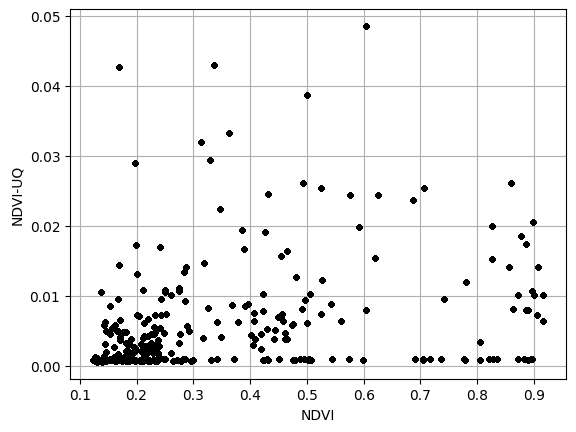

In [223]:
plt.scatter(x=filtered_results.NDVI, y=filtered_results["NDVI-UQ"], color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("NDVI")
plt.ylabel("NDVI-UQ")
plt.show()

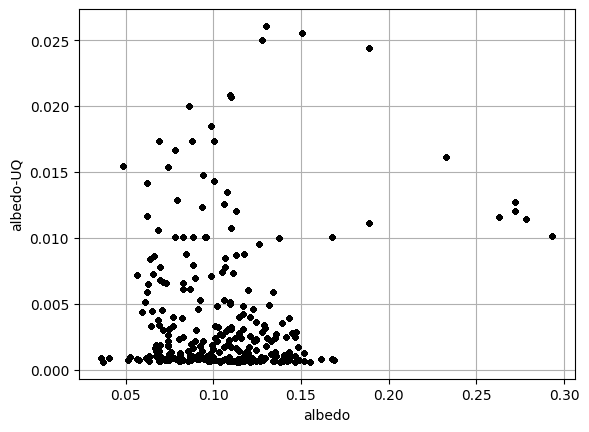

In [224]:
plt.scatter(x=filtered_results.albedo, y=filtered_results["albedo-UQ"], color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("albedo")
plt.ylabel("albedo-UQ")
plt.show()

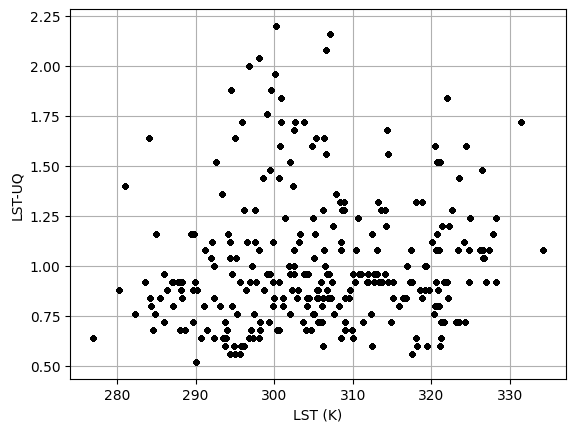

In [225]:
plt.scatter(x=filtered_results.LST, y=filtered_results["LST_err"], color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("LST (K)")
plt.ylabel("LST-UQ")
plt.show()

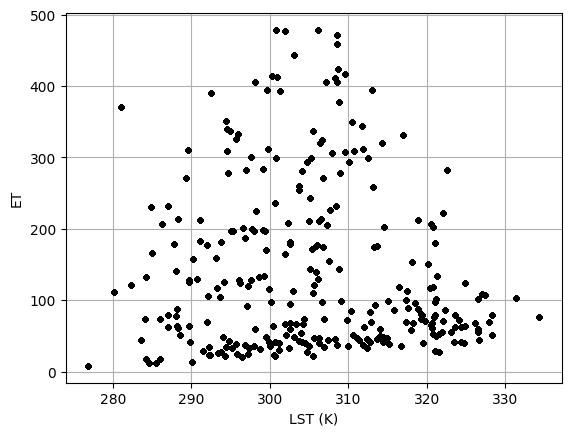

In [226]:
plt.scatter(x=filtered_results.LST, y=filtered_results.PTJPLSMinst, color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("LST (K)")
plt.ylabel("ET")
plt.show()

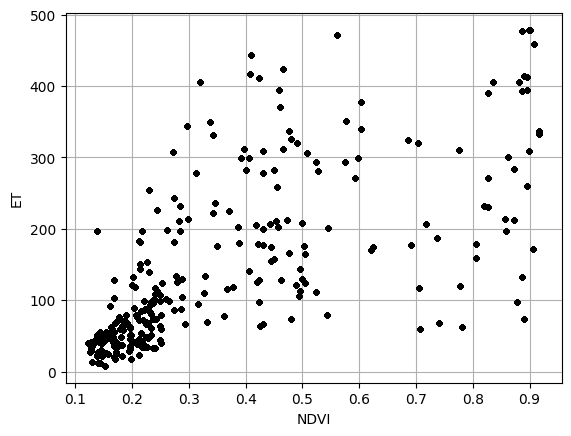

In [227]:
plt.scatter(x=filtered_results.NDVI, y=filtered_results.PTJPLSMinst, color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("NDVI")
plt.ylabel("ET")
plt.show()

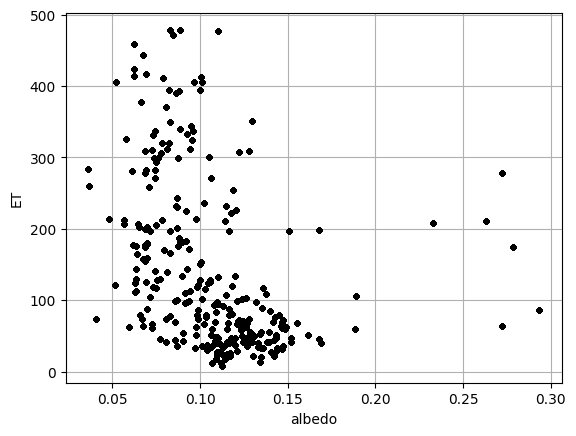

In [228]:
plt.scatter(x=filtered_results.albedo, y=filtered_results.PTJPLSMinst, color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("albedo")
plt.ylabel("ET")
plt.show()

Text(0.5, 0, 'NDVI')

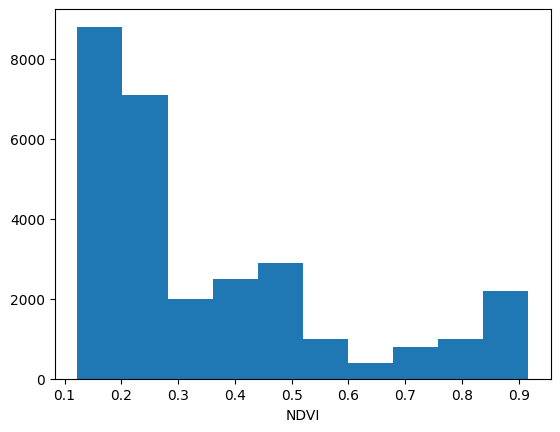

In [229]:
plt.hist(x=filtered_results.NDVI)
plt.xlabel("NDVI")

Text(0.5, 0, 'NDVI UQ')

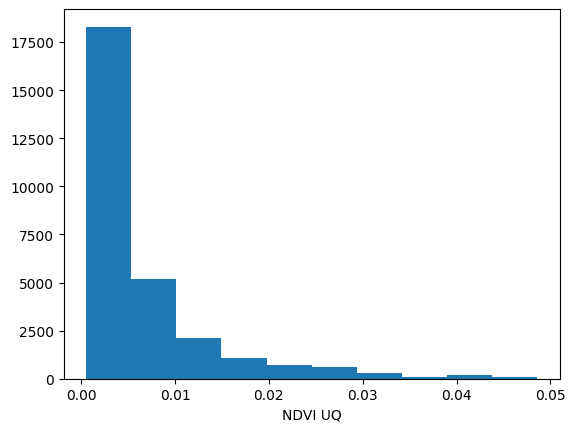

In [230]:
plt.hist(x=filtered_results["NDVI-UQ"])
plt.xlabel("NDVI UQ")

<Axes: >

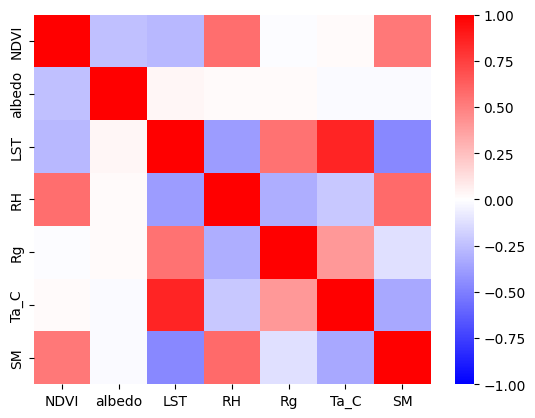

In [231]:
sns.heatmap(input_df[["NDVI","albedo","LST","RH","Rg","Ta_C","SM"]].corr(), cmap='bwr', vmin=-1, vmax=1)